In [1]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
print(sys.path)

from model_runs.model_run_helpers import *
from model_runs.distributed_gpu_helpers import *
from visualisations.visualisation_helpers import *
import os
print(os.getcwd())


['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages', '/homes/vk223/ProjectFlood', '/home/vkhandekar/project_flood']
/homes/vk223/ProjectFlood/evaluation


In [2]:
from evaluation.model_evaluation_helpers import *
os.environ["PROJECT_FLOOD_DATA"] = "/homes/vk223/ProjectFlood/static/imperial_data_paths.json"
os.environ["PROJECT_FLOOD_CORE_PATHS"] = "/homes/vk223/ProjectFlood/static/imperial_core_paths.json"
print(os.environ["PROJECT_FLOOD_DATA"])
resolution = 256


/homes/vk223/ProjectFlood/static/imperial_data_paths.json


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
torch.manual_seed(42)
# Load newly trained best, final models
final_sep_branch_model, _, _, final_sep_branch_params = load_checkpoint("/homes/vk223/ProjectFlood/models/saved_models/ConvLSTMMerged_epochs500_batchsize16_lr0p001_precedingrainfall1_dropout0p3_outputchannels8_convblocklayers2_convLSTMlayers2_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")
final_merged_model, _, _, final_merged_params = load_checkpoint("/homes/vk223/ProjectFlood/models/saved_models/ConvLSTMSeparateBranches_epochs500_batchsize32_lr0p001_precedingrainfall1_dropout0p5_outputchannels8_convblocklayers2_convLSTMlayers1_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")

dict_keys(['epochs', 'batchsize', 'lr', 'precedingrainfall', 'dropout', 'outputchannels', 'convblocklayers', 'convLSTMlayers', 'optim', 'criterion', 'transforms', 'res'])
dict_keys(['epochs', 'batchsize', 'lr', 'precedingrainfall', 'dropout', 'outputchannels', 'convblocklayers', 'convLSTMlayers', 'optim', 'criterion', 'transforms', 'res'])


/homes/vk223/ProjectFlood/evaluation/model_evaluation_helpers.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)
/vol/bitbucket/vk223/pro

In [6]:
sep_branch_test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=final_sep_branch_params['precedingrainfall'], forecast_rainfall_days=1, 
                                                transform=None, batch_size=16, shuffle=False, num_workers=4)
    
merged_test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=final_merged_params['precedingrainfall'], forecast_rainfall_days=1, 
                                            transform=None, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
from visualisations.visualisation_helpers import *
# Plot image
with torch.no_grad():
    size = 3

    sep_branch_flooded_images = []
    sep_branch_non_flooded_images = []
    for inputs, targets, flooded in sep_branch_test_dataloader:
        sep_branch_outputs = final_sep_branch_model(inputs)
        for i in range(len(flooded)):
            if flooded[i] == 1 and len(sep_branch_flooded_images) < size:
                sep_branch_flooded_images.append((sep_branch_outputs[i], targets[i], flooded[i]))
            elif flooded[i] == 0 and len(sep_branch_non_flooded_images) < size:
                sep_branch_non_flooded_images.append((sep_branch_outputs[i], targets[i], flooded[i]))
            # Stop if we've collected 4 images in each category
            if len(sep_branch_flooded_images) >= size and len(sep_branch_non_flooded_images) >= size:
                break
        if len(sep_branch_flooded_images) >= 4 and len(sep_branch_non_flooded_images) >= 4:
            break

    merged_flooded_images = []
    merged_non_flooded_images = []
    for inputs, targets, flooded in merged_test_dataloader:
        merged_outputs = final_merged_model(inputs)
        for i in range(len(flooded)):
            if flooded[i] == 1 and len(merged_flooded_images) < size:
                merged_flooded_images.append((merged_outputs[i], targets[i], flooded[i]))
            elif flooded[i] == 0 and len(merged_non_flooded_images) < size:
                merged_non_flooded_images.append((merged_outputs[i], targets[i], flooded[i]))
            # Stop if we've collected 4 images in each category
            if len(merged_flooded_images) >= size and len(merged_non_flooded_images) >= size:
                break
        if len(merged_flooded_images) >= 4 and len(merged_non_flooded_images) >= 4:
            break
    
    with open(os.environ["PROJECT_FLOOD_CORE_PATHS"]) as core_config_file:
        core_config = json.load(core_config_file)
    dimension_string = core_config[f"rainfall_reprojection_master_256"]
    match = re.search(r'_(\d+)_(\d+)\.tif$', dimension_string)
    new_dimension_right, new_dimension_bottom = int(match.group(1)), int(match.group(2))


    selected_sep_branch_outputs = [img[0] for img in sep_branch_flooded_images + sep_branch_non_flooded_images]
    selected_sep_branch_outputs = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_sep_branch_outputs] #crop


    selected_merged_outputs = [img[0] for img in merged_flooded_images + merged_non_flooded_images]
    selected_merged_outputs = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_merged_outputs] #crop

    model_names = ['Branched', 'Merged']
    selected_model_outputs = [selected_sep_branch_outputs, selected_merged_outputs]

    selected_targets = [img[1] for img in sep_branch_flooded_images + sep_branch_non_flooded_images]
    selected_targets = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_targets] #crop


    selected_targets_flooded = [img[2] for img in sep_branch_flooded_images + sep_branch_non_flooded_images] #boolean for flooded or not

    # Do plotting
    with open(os.environ["PROJECT_FLOOD_DATA"]) as data_config_file:
        data_config = json.load(data_config_file)
    plot_filename = os.path.join(data_config["model_results_path"], "final_plots.png")
    plot_final_model_output_vs_label(model_names, selected_model_outputs, selected_targets, selected_targets_flooded, plot_filename)

In [54]:
with open(os.environ["PROJECT_FLOOD_DATA"]) as data_config_file:
    data_config = json.load(data_config_file)
with open(os.environ["PROJECT_FLOOD_CORE_PATHS"]) as core_config_file:
    core_config = json.load(core_config_file)
dimension_string = core_config[f"rainfall_reprojection_master_{resolution}"]
match = re.search(r'_(\d+)_(\d+)\.tif$', dimension_string)
new_dimension_right, new_dimension_bottom = int(match.group(1)), int(match.group(2))


# model = final_sep_branch_model.to(device)
model = final_sep_branch_model
model.eval()
criterion = getattr(torch.nn, final_sep_branch_params['criterion'])()

# Load the True/False mask
mask = np.load(os.path.join(data_config["model_results_path"], f"perm_water_mask_{resolution}.npy"))
print(mask.shape)

(256, 203)


In [55]:
thresholds = np.arange(0, 1.05, 0.05)
confusion_matrices = {thr: np.zeros((2, 2)) for thr in thresholds}
precision_scores = {thr: 0 for thr in thresholds}
recall_scores = {thr: 0 for thr in thresholds}
accuracy_scores = {thr: 0 for thr in thresholds}

total_samples = 0
total_masked_samples = 0

total_loss = 0
total_rmse = 0
total_mae = 0
total_psnr = 0
total_ssim = 0

with torch.no_grad():
    for inputs, labels, _ in sep_branch_test_dataloader: #batch size is first dim. (BXY)
        # inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
        inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
        outputs = model(inputs)

        # Crop the outputs and labels as required
        cropped_outputs = outputs[..., 0:new_dimension_bottom, 0:new_dimension_right]  
        cropped_labels = labels[..., 0:new_dimension_bottom, 0:new_dimension_right]
        # print(cropped_outputs.shape)

        # Apply mask (retain False values)
        mask_torch = torch.from_numpy(mask)
        mask_torch = mask_torch.unsqueeze(0)
        mask_torch = mask_torch.expand(cropped_outputs.size(0), -1, -1)

        masked_outputs = cropped_outputs[~mask_torch]
        masked_labels = cropped_labels[~mask_torch]

        # 1. Calculate PSNR and SSIM on cropped (but not masked) images
        psnr_value = PSNR(cropped_outputs, cropped_labels)
        ssim_value = SSIM(cropped_outputs, cropped_labels)
        total_psnr += psnr_value.item()
        total_ssim += ssim_value.item()
        rmse_loss = RMSELoss(cropped_outputs, cropped_labels)
        mae_loss = MAELoss(cropped_outputs, cropped_labels)

        total_rmse += rmse_loss.item()
        total_mae += mae_loss.item()

        # Calculate the total loss
        loss = criterion(cropped_outputs, cropped_labels).item()
        total_loss += loss
        total_samples += cropped_labels.size(0)
        total_masked_samples += masked_labels.size(0)
        # print('cropped label size:', cropped_labels.size(0))
        # print('masked label size:', masked_labels.size())

        # 2. Apply different thresholds and calculate confusion matrices
        for thr in thresholds:
            binary_output = (masked_outputs > thr).float()
            binary_output = binary_output.cpu().numpy().flatten()
            binary_labels = masked_labels.cpu().numpy().flatten()

            cm = confusion_matrix(binary_labels, binary_output, labels=[0, 1])
            confusion_matrices[thr] += cm

            # Calculate accuracy at this threshold
            correct_predictions = (binary_output == binary_labels).sum()
            accuracy_scores[thr] += correct_predictions

/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/pr

In [58]:
# Calculate averages
avg_rmse = total_rmse / len(sep_branch_test_dataloader)
avg_mae = total_mae / len(sep_branch_test_dataloader)
avg_psnr = total_psnr / len(sep_branch_test_dataloader)
avg_ssim = total_ssim / len(sep_branch_test_dataloader)
average_loss = total_loss / len(sep_branch_test_dataloader)
print('psnr:', avg_psnr)
print('ssim:', avg_ssim)
print('average loss:', average_loss)


# Calculate average accuracy for each threshold
for thr in thresholds:
    accuracy_scores[thr] /= total_masked_samples

metric_accumulator = {
    'average_rmse': avg_rmse,
    'average_mae': avg_mae,
    'average_psnr': avg_psnr,
    'average_ssim': avg_ssim,
    'average_loss': average_loss,
    'confusion_matrices': confusion_matrices, #tn, fp, fn, tp
    'accuracy_scores': accuracy_scores
}

# Calculate the final precision and recall
precision_scores = {}
recall_scores = {}
f1_scores = {}
false_positive_rates = {}
for thr, cm in metric_accumulator['confusion_matrices'].items():
    tn, fp, fn, tp = cm.ravel()  # Unpack the 2x2 confusion matrix
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    precision_scores[thr] = precision
    recall_scores[thr] = recall
    f1_scores[thr] = (2*precision*recall)/(precision+recall) if (precision + recall) > 0 else np.nan

    false_positive_rates[thr] = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    
metric_accumulator['precision_scores'] = precision_scores
metric_accumulator['recall_scores'] = recall_scores
metric_accumulator['f1_scores'] = f1_scores
metric_accumulator['false_positive_rates'] = false_positive_rates


psnr: 14.693440914154053
ssim: 0.6088900566101074
average loss: 0.11463938467204571


In [59]:
metric_accumulator

{'average_rmse': 0.1843477450311184,
 'average_mae': 0.2656709626317024,
 'average_psnr': 14.693440914154053,
 'average_ssim': 0.6088900566101074,
 'average_loss': 0.11463938467204571,
 'confusion_matrices': {np.float64(0.0): array([[      0., 2344219.],
         [      0.,   92365.]]),
  np.float64(0.05): array([[1824063.,  520156.],
         [   6616.,   85749.]]),
  np.float64(0.1): array([[1999085.,  345134.],
         [  12620.,   79745.]]),
  np.float64(0.15000000000000002): array([[2081756.,  262463.],
         [  18274.,   74091.]]),
  np.float64(0.2): array([[2132962.,  211257.],
         [  23113.,   69252.]]),
  np.float64(0.25): array([[2169812.,  174407.],
         [  27390.,   64975.]]),
  np.float64(0.30000000000000004): array([[2196761.,  147458.],
         [  31219.,   61146.]]),
  np.float64(0.35000000000000003): array([[2217885.,  126334.],
         [  34811.,   57554.]]),
  np.float64(0.4): array([[2234717.,  109502.],
         [  38226.,   54139.]]),
  np.float64(0

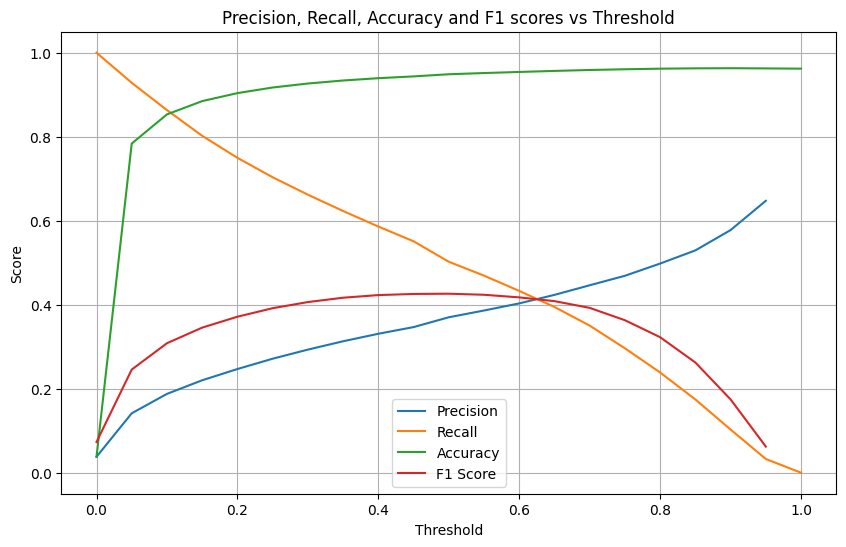

In [48]:
import matplotlib.pyplot as plt

# Extract thresholds, precision, recall, and accuracy from the dictionaries
thresholds = list(metric_accumulator['precision_scores'].keys())
precision_scores = list(metric_accumulator['precision_scores'].values())
recall_scores = list(metric_accumulator['recall_scores'].values())
accuracy_scores = list(metric_accumulator['accuracy_scores'].values())
f1_scores = list(metric_accumulator['f1_scores'].values())

# Create a plot
plt.figure(figsize=(10, 6))

# Plot Precision
plt.plot(thresholds, precision_scores, label='Precision')

# Plot Recall
plt.plot(thresholds, recall_scores, label='Recall')

# Plot Accuracy
plt.plot(thresholds, accuracy_scores, label='Accuracy')

plt.plot(thresholds, f1_scores, label='F1 Score')

# Adding title and labels
plt.title('Precision, Recall, Accuracy and F1 scores vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


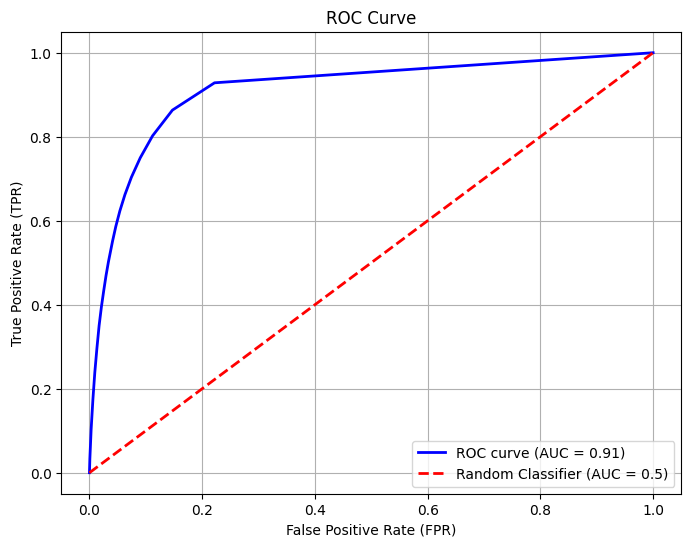

Calculated AUC: 0.91


In [27]:
from sklearn.metrics import auc
fpr = list(metric_accumulator['false_positive_rates'].values())
tpr = list(metric_accumulator['recall_scores'].values())

# Calculate AUC using sklearn's auc function
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')

# Plot the random classifier line (y = x)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

# Labels and Title
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Display the plot
plt.grid(True)
plt.show()

# Print AUC
print(f'Calculated AUC: {roc_auc:.2f}')

In [29]:
metric_accumulators = [metric_accumulator, metric_accumulator]
model_names = ['Branched', 'Merged']
data = {}
for m in metric_accumulators:
    for key, value in m.items():
        if key not in data:
            data[key] = []
        data[key].append(value)

df = pd.DataFrame(data, index=model_names).T
df


,Branched,Merged
average_rmse,0.195007,0.195007
average_mae,0.27971,0.27971
average_psnr,14.693441,14.693441
average_ssim,0.60889,0.60889
average_loss,0.0,0.0
confusion_matrices,"{0.0: [[0.0, 2344219.0], [0.0, 92365.0]], 0.05...","{0.0: [[0.0, 2344219.0], [0.0, 92365.0]], 0.05..."
accuracy_scores,"{0.0: 0.03790757880705118, 0.05: 0.78380716609...","{0.0: 0.03790757880705118, 0.05: 0.78380716609..."
precision_scores,"{0.0: 0.03790757880705118, 0.05: 0.14152218582...","{0.0: 0.03790757880705118, 0.05: 0.14152218582..."
recall_scores,"{0.0: 1.0, 0.05: 0.9283711362529097, 0.1: 0.86...","{0.0: 1.0, 0.05: 0.9283711362529097, 0.1: 0.86..."
f1_scores,"{0.0: 0.07304615474649746, 0.05: 0.24560413593...","{0.0: 0.07304615474649746, 0.05: 0.24560413593..."


In [ ]:

df.to_csv(filename)